In [161]:
import math
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

In [162]:
def f(x): 
    return 3*x**2 - 4*x +5

In [163]:
f(3.0)

20.0

In [164]:
xs = np.arange(-5,5,0.25) # returns array of sequenced 0.25 intervals between -5 and 5
ys = f(xs) 
plt.plot(xs, ys)

# plot interval xs for different f(xs), which is a standard function

In [165]:
# What is the derivative ??? change of f(x) for a small h 

h = 0.00000000000001
x = 3.0 
(f(x+h) - f(x))/h # at three, the slope is basically 14. 

14.210854715202004

In [166]:
# complex case 

a = 2.0 
b = -3.0 
c = 10.0 
d = a*b + c 
print(d)

4.0


In [167]:
h = 0.0001 

# inputs 

a = 2.0 
b = -3.0 
c = 10.0 

d1 = a*b + c 
b += h # derivative is just bumping and calculating the change of a or b's effect on d
d2 = a*b + c

print('d1:', d1) 
print('d2:', d2) 
print('slope:', (d2-d1)/h) 

d1: 4.0
d2: 4.0002
slope: 2.0000000000042206


In [168]:
class Value: 

    def __init__(self, data, _children=(), _op='', label = ''): # self is a requirement for an inwards pass 
        self.data = data 
        self._prev = set(_children) # set and convenience
        self._op = _op  
        self.label = label
        self.grad = 0.0 

    def __repr__(self): # official string 
        return f"Value(data = {self.data})" # repr function to return a string 
    def __add__(self, other): 
        out = Value(self.data + other.data, (self,other), '+')
        return out 
    def __mul__(self, other): 
        out = Value(self.data * other.data, (self,other), '*')
        return out 
    



a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b') 
c = Value(10.0, label = 'c') 
e = a*b; e.label = 'e'
d= e + c; d.label = 'd' # now it knows 
f = Value(-2.0, label = 'f')
L = d*f ; L.label = 'L'
L
# a.__add__(b) # we need to define add, subtract, and all the other combinations. 

Value(data = -8.0)

In [169]:
d._prev # storing the value of multiply betwen a and b, then c value 

{Value(data = -6.0), Value(data = 10.0)}

In [170]:
d._op # d produced by the addition of those values. all of this is good data structures 

'+'

In [171]:
# pip install python-graphviz

In [172]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [178]:
# copying 

class Value: 

    def __init__(self, data, _children=(), _op='', label = ''): # self is a requirement for an inwards pass 
        self.data = data 
        self.grad = 0.0 
        self._backward = lambda: None 
        self._prev = set(_children) # set and convenience
        self._op = _op  
        self.label = label

    def __repr__(self): # official string 
        return f"Value(data = {self.data})" # repr function to return a string 
    def __add__(self, other): 
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')
        def _backward():
            self.grad += 1.0*out.grad 
            other.grad += 1.0*out.grad 
        out._backward = _backward 

        return out 
    def __neg__(self): 
        return self * -1 
    def __sub__(self, other): 
        return self + (-other)    
      
    def __mul__(self, other): 
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')
        def _backward():
            self.grad = other.data*out.grad 
            other.grad = self.data*out.grad 
        out._backward = _backward 
        return out 
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += out.grad*out.grad  
        out._backward = _backward 
        return out 
        
    
    def __rmul__(self, other): 
        return self * other 

    def __truediv__(self, other): 
        return self * other**-1    


    def __pow__(self, other): 
        assert isinstance (other, (int, float))
        out = Value (self.data**other, (self,), f'**(other)')   
        def backward(): 
            self.grad += other * self.data ** (other-1) * out.grad 
        out._backward = backward() 

        return out 


    def tanh(self):
        n = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad = (1 - t**2 ) * out.grad 
        out._backward = _backward 

        return out
    
    def backward(self):
        topo = [] 
        visited = set() 
        def build_topo(v): 
            if v not in visited: 
                visited.add(v)
                for child in v._prev: 
                    build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0 
        for node in reversed(topo): 
            node._backward() 

In [183]:
x1 = Value(2,0)
x2 = Value(0, label = 'x2')


w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

b = Value(6.88, label = 'b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2,label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward() 

TypeError: 'int' object is not iterable

In [174]:
from graphviz import Digraph 

def trace(root): 
# builds a set of all nodges and edges in a graph
    nodes, edges = set(), set() 
    def build(v): 
        if v not in nodes: 
            nodes.add(v)
            for child in v._prev: 
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges 

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) # left to right 

    nodes, edges = trace(root) 
    for n in nodes: 
        uld = str(id(n))

        dot.node(name = uld, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data,n.grad), shape = 'record')
        if n._op:
            dot.node(name = uld + n._op, label = n._op)

            dot.edge(uld+n._op, uld)

    for n1, n2 in edges: 
        dot.edge(str(id(n1)), str(id(n2)) +n2._op)
    return dot

In [186]:
a = Value(2.0, label= 'x1')

In [187]:
x1 = Value(2,0, label = 'x1')
x2 = Value(0, label = 'x2')


w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

b = Value(6.88, label = 'b')

# x1w1 = x1 * w1; x1w1.label = 'x1w1'
# x2w2 = x2 * w2; x2w2.label = 'x2w2'

# x1w1x2w2 = x1w1 + x2w2; x1w1x2w2,label = 'x1w1x2w2'
# n = x1w1x2w2 + b; n.label = 'n'
# o = n.tanh(); o.label = 'o'
# o.backward() 

TypeError: 'int' object is not iterable

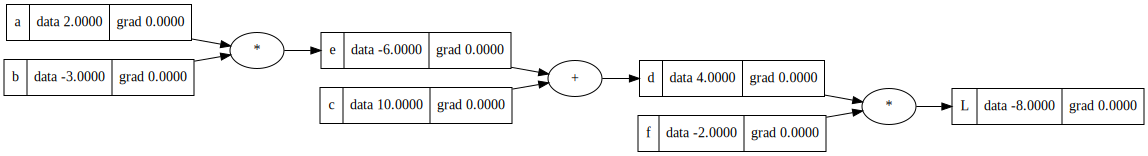

In [184]:
draw_dot(L)
# L.grad = 1.0
# f.grad = 4.0 
# d.grad = -2.0
# c.grad = -2.0 
# e.grad = -2.0
# a.grad = 6.0 
# b.grad = -4.0 

####################


# back propagation and calculate the gradient in the intermediate values derivative with respective to L all the way back 
# usually it is weights 



# DL / DC = DD / DC * DL / DD; DD / DC = 1 and DD / DE = 1
# DL / DD  = DL/DL * DL / DD
# DL / DA = DL/DE * DE/DA 

# https://graphviz.org/ graph vic API 
# able to build out mathematical expression to be scalared value for a forward pass 

In [120]:
def lol(): 
    # checker 
    h = 0.0001    
    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b') 
    c = Value(10.0, label = 'c') 
    e = a*b; e.label = 'e'
    d= e + c; d.label = 'd' # now it knows 
    f = Value(-2.0, label = 'f')
    L = d*f ; L.label = 'L'
    L1 = L.data 

    
    a = Value(2.0+h, label = 'a')
    b = Value(-3.0, label = 'b') 
    c = Value(10.0, label = 'c') 
    e = a*b; e.label = 'e'
    d= e + c; d.label = 'd' # now it knows 
    f = Value(-2.0, label = 'f')
    L = d*f ; L.label = 'L'
    L2 = L.data 

    print((L2-L1)/h) # DA / DL
lol() 

# 

6.000000000021544


In [ ]:
# pytorch ! 